## N-Body problems

Many physical problems require the evaluation of all pairwise interactions of a large number of particles, so-called N-body problems. These problems arise in molecular dynamics, astrodynamics and electromagnetics among others. 

Their pairwise interactions can be expressed as:

\begin{equation}
f_i = \sum_{j=1}^n{P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)w_j} \ \ \ \text{for } i=1,2,...,n 
\end{equation}

*  where subscripts $i$,  $j$ respectively denote *target* and *source*
*  $f_i$ can be a *potential* (or *force*) at target point $i$
*  $w_j$ is the *source weight* 
*  $\boldsymbol{x}_i, \boldsymbol{x}_j$ are the *spatial positions* of particles 
*  $P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)$ is the *interaction kernel*. 

In order to evalute the potential $f_i$ at a target point $i$, we have to loop over each source particle $j$. Since there are $n$ target points $i$, this 'brute-force' approach costs $\mathcal{O} \left(n^2 \right)$ operations. 

One possible approach in this kind of problem is to define a few classes, say `Point` and `Particle` and then loop over the objects and perform the necessary point-to-point calculations.

## How do we use Numba on this problem?
Problem: Numba doesn't support jitting native Python classes.  There is a `jit_class` structure in Numba but it's still in early development.

But it's nice to have attributes for literate programming.

Solution: NumPy custom dtypes.

In [1]:
import numpy as np

class Point():
    """    
    Arguments:
        domain: the domain of random generated coordinates x,y,z, 
                default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    def __init__(self, domain=1.0):
        self.x = domain * np.random.random()
        self.y = domain * np.random.random()
        self.z = domain * np.random.random()
            
    def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5

class Particle(Point):
    """    
    Attributes:
        m: mass of the particle
        phi: the potential of the particle
    """
    
    def __init__(self, domain=1.0, m=1.0):
        Point.__init__(self, domain)
        self.m = m
        self.phi = 0.

In [3]:
particle_dtype = np.dtype({'names':['x','y','z','m','phi'], 
                             'formats':[np.double, 
                                        np.double, 
                                        np.double, 
                                        np.double, 
                                        np.double]})

### Exercise 1

Write a function `create_n_random_particles` that takes the arguments `n` (number of particles), `m` (mass of every particle) and a domain within to generate a random number (as in the class above).
It should create an array with `n` elements and `dtype=particle_dtype` and then return that array.

For each particle, the mass should be initialized to the value of `m` and the potential `phi` initialized to zero.

For the `x` component of a given particle `p`, you might do something like

```python
p['x'] = domain * numpy.random.random()
```

In [6]:
from numba import njit

@njit(cache=True)
def create_n_random_particles(n, m, domain = 1.0):
    '''
    Creates `n` particles with mass `m` with random coordinates
    between 0 and `domain`
    '''
    parts = np.zeros((n), dtype = particle_dtype)
    
    for i in range(n):
        parts[i]['x'] = domain * np.random.random()
        parts[i]['y'] = domain * np.random.random()
        parts[i]['z'] = domain * np.random.random()
        parts[i]['m'] = 1 / n
        parts[i]['phi'] = 0.0
    return parts

In [7]:
# test it
n = 1000
m = 1/n
parts = create_n_random_particles(n = n, m = m, domain = 1.0)

In [8]:
%timeit create_n_random_particles(n = n, m = m, domain = 1.0)

100000 loops, best of 3: 18.4 µs per loop


### Exercise 2

Write a JITted function `distance` to calculate the distance between two particles of dtype `particle_dtype`

Here's the `distance` method from the `Particle` class as a reference:

```python
def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5
```

In [9]:
@njit(cache=True)
def distance(part1, part2):
    '''calculate the distance between two particles'''
    return ((part1['x'] - part2['x'])**2 + 
    (part1['y'] - part2['y'])**2 + 
    (part1['z'] - part2['z'])**2)**0.5

In [10]:
%timeit distance(parts[54], parts[563])

The slowest run took 74835.14 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.93 µs per loop


In [11]:
# test it
a = 343
b = 876
dist = distance(parts[a], parts[b])
dist

0.3528955177145777

### Exercise 3
Modify the original `direct_sum` function (copied below for reference) to instead work a NumPy array of particles.  Loop over each element in the array and calculate its total potential.

```python
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r


In [14]:
parts = create_n_random_particles(n = 1000, m = 1/1000, domain = 1.0)

In [12]:
@njit(cache=True)
def direct_sum_jit(particles):
    for k in range(particles.shape[0]-1):
        for i in range(particles.shape[0]-1):
            if k == i:
                None
            else:
                r = distance(particles[k], particles[i])
                particles[k]['phi'] += particles[i]['m']/r
    return particles

In [13]:
direct_sum_jit(parts)[0]['phi']

2.0148962168695936

In [15]:
n = 1000
particles = [Particle(m = 1 / n) for i in range(n)]

In [16]:
def direct_sum(particles):
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r
    return particles

In [17]:
direct_sum(particles)[0].phi

2.244669876563057

Graphs

In [18]:
results_jit = []
for n_parts in range(100, 2000, 100):
    n = n_parts
    m = 1 / n_parts
    parts_current = create_n_random_particles(n = n, m = m, domain = 1.0)
    t = %timeit -n 1 -o -q direct_sum_jit(parts_current)
    results_jit.append(t)

In [19]:
results_jit

[<TimeitResult : 1 loop, best of 3: 33.9 µs per loop>,
 <TimeitResult : 1 loop, best of 3: 134 µs per loop>,
 <TimeitResult : 1 loop, best of 3: 311 µs per loop>,
 <TimeitResult : 1 loop, best of 3: 959 µs per loop>,
 <TimeitResult : 1 loop, best of 3: 860 µs per loop>,
 <TimeitResult : 1 loop, best of 3: 1.25 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 1.9 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 2.17 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 2.74 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 4.77 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 4.13 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 4.93 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 5.8 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 6.77 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 7.6 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 8.74 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 9.89 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 11 ms per loop>,
 <TimeitResult : 1 

In [20]:
results = []
for n_parts in range(100, 2000, 100):
    n = n_parts
    m = 1 / n_parts
    parts_current = particles = [Particle(m = m) for i in range(n)]
    t = %timeit -n 1 -o -q direct_sum(parts_current)
    results.append(t)

In [21]:
results

[<TimeitResult : 1 loop, best of 3: 6.49 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 25.6 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 57.8 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 104 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 163 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 235 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 322 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 417 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 525 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 648 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 783 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 945 ms per loop>,
 <TimeitResult : 1 loop, best of 3: 1.09 s per loop>,
 <TimeitResult : 1 loop, best of 3: 1.26 s per loop>,
 <TimeitResult : 1 loop, best of 3: 1.47 s per loop>,
 <TimeitResult : 1 loop, best of 3: 1.65 s per loop>,
 <TimeitResult : 1 loop, best of 3: 1.87 s per loop>,
 <TimeitResult : 1 loop, best of 3: 2.09 s per loop>,
 <TimeitResult : 1 loop, 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

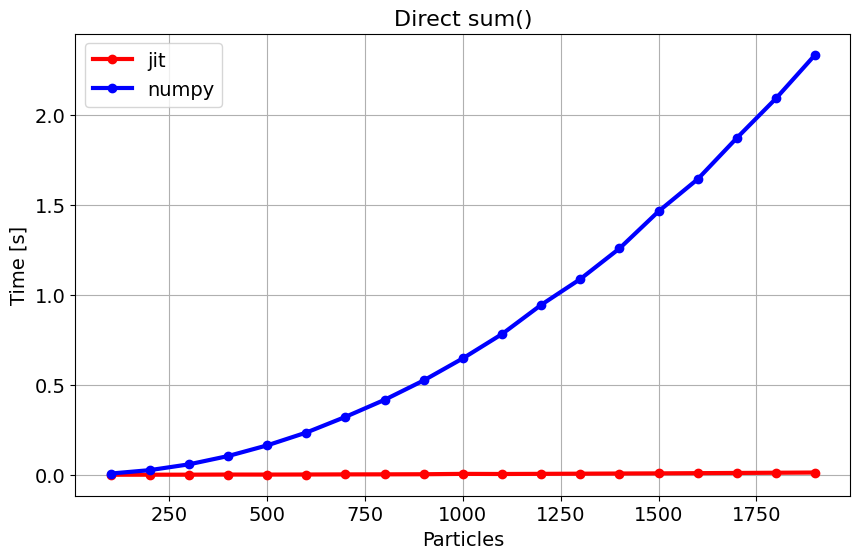

In [35]:
plt.style.use('default')
plt.figure(figsize=(10,6))
plt.plot(np.arange(100, 2000, 100), [i.best for i in results_jit],'o-', linewidth = 3.0, color = "red")
plt.plot(np.arange(100, 2000, 100), [i.best for i in results],'o-', linewidth = 3.0, color = "blue")
plt.title('Direct sum()', fontsize=16)

plt.xlabel('Particles', fontsize=14)
plt.ylabel('Time [s]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['jit', 'numpy'], fontsize=14);
plt.grid()
plt.show()

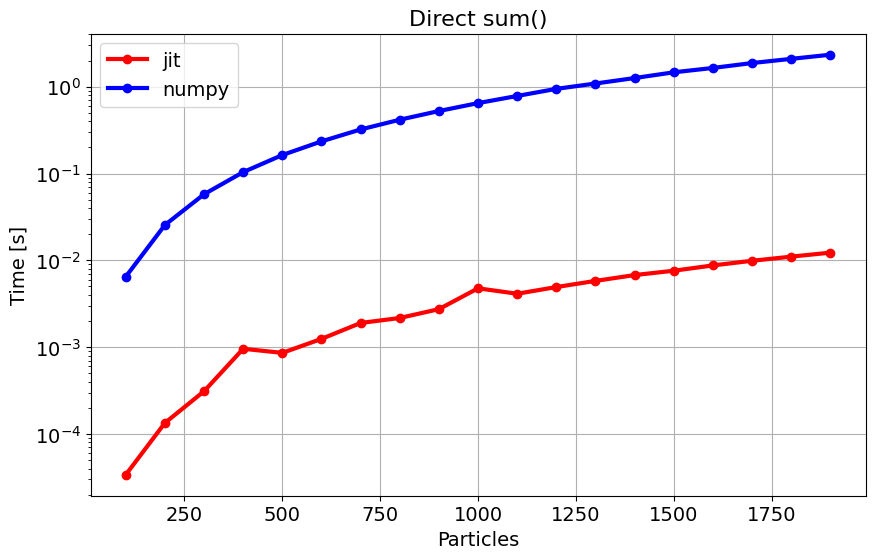

In [36]:

plt.style.use('default')
plt.figure(figsize=(10,6))
plt.plot(np.arange(100, 2000, 100), [i.best for i in results_jit],'o-', linewidth = 3.0, color = "red")
plt.plot(np.arange(100, 2000, 100), [i.best for i in results],'o-', linewidth = 3.0, color = "blue")
plt.title('Direct sum()', fontsize=16)
plt.yscale('log')
plt.xlabel('Particles', fontsize=14)
plt.ylabel('Time [s]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['jit', 'numpy'], fontsize=14);
plt.grid()
plt.show()